# Project

### Anbar Aizenman, Ilya Lukibanov, Irina Osipova, Isamar Troncoso

Import libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
import matplotlib.pyplot as plt
import random
from sklearn import tree
from sklearn import metrics
from scipy.sparse import csr_matrix
import math
import scipy
from ipywidgets import IntProgress
from IPython.display import display
import time

In [2]:
def Causal_Forest_Estimator(X, y, D, W, s, B, clf):
    """Estimate the causal forest.

    Keyword arguments:
    X -- control variables (features)
    y -- outcome variable (target)
    D -- eligibility status; not random treatment - people who decided to use Medicaid
    W -- intension to treat (lottery) - use the same as instrument in IV
    s -- side of the train sample
    B -- number of trees in the forest (default 10,000)
    clf -- basic classifier
    """
    #vectors of results:
    #r2 for each tree
    r = np.zeros(B)
    #mean effect for each observation in each tree
    m = np.zeros((B,n))
    #treatment effect for each observation in each tree
    tef = np.zeros((B,n))
    #matrix of occurances
    N = np.zeros((B,n))
    f = IntProgress(min=0, max=B) # instantiate the bar
    display(f) # display the bar
    for i in range(0,B):
        #create mask to select subsample for the trees
        subSampleMask = random.sample(range(0, n), s)
        #we need this to compute variance (see equation 8 in the WA paper)
        z = np.zeros(n)
        for j in subSampleMask:
            z[j] = 1
        N[i] = z
        # Create set I (to estimate leaf-wise responses)
        setIMask = random.sample(subSampleMask, np.int(np.ceil(s/2.)))
        setI = X[setIMask]
        # Create set J (to grow a tree)
        setJMask = [i for i in subSampleMask if i not in setIMask]
        setJ = X[setJMask]
        # Create tree on the J set
        clf = clf.fit(setJ, y[setJMask])
        # Out of sample R^2, but not honest estimation of the model (use the same y's from sample J to estimate the model)
        r[i] = clf.score(setI,y[setIMask])
        # extract tree structure to build honest model
        ni = clf.decision_path(X).toarray()
        # use only y's from sample I
        ni_maskI = clf.decision_path(setI).toarray()
        # extract the nest number for each observation
        # for full data
        for j in range(0,ni.shape[1]):
            ni[:,j] = ni[:,j] * j
        # for restricted 
        for j in range(0,ni_maskI.shape[1]):
            ni_maskI[:,j] = ni_maskI[:,j] * j
        # array of indexes of nests to calculate average among them:
        y_nest = np.max(ni,axis=1)
        y_nest_maskI = np.max(ni_maskI,axis=1).reshape(ni_maskI.shape[0],1)
        #y's with mask I
        y_maskI = y[setIMask].reshape(y[setIMask].shape[0],1)
        # treatments with mask I
        W_maskI = W[setIMask].reshape(y_nest_maskI.shape[0],1)
        D_maskI = D[setIMask].reshape(y_nest_maskI.shape[0],1)
        # to collect mean and treatment effects
        nest_m = np.zeros(ni_maskI.shape[1])
        nest_t = np.zeros(ni_maskI.shape[1])
        # go through all final nodes to compute effects in them
        for j in np.unique(y_nest_maskI):
            # mean effect
            su = np.sum(y_maskI[y_nest_maskI==j])/np.sum([y_nest_maskI==j])
            nest_m[j] = su
            # treatment effect (LATE)
            e1 = np.sum(y_maskI[np.multiply((y_nest_maskI==j).reshape(y_nest_maskI.shape[0],1),(W_maskI == 1).reshape(y_nest_maskI.shape[0],1))])/np.sum([np.multiply((y_nest_maskI==j).reshape(y_nest_maskI.shape[0],1),(W_maskI == 1).reshape(y_nest_maskI.shape[0],1))] )
            e0 = np.sum(y_maskI[np.multiply((y_nest_maskI==j).reshape(y_nest_maskI.shape[0],1),(W_maskI == 0).reshape(y_nest_maskI.shape[0],1))])/np.sum([np.multiply((y_nest_maskI==j).reshape(y_nest_maskI.shape[0],1),(W_maskI == 0).reshape(y_nest_maskI.shape[0],1))] )
            te = e1 - e0
            # actually, WA does not have have following part in their model, but assimptotic derivations should be the same for LATE
            d1 = np.sum(D_maskI[np.multiply((y_nest_maskI==j).reshape(y_nest_maskI.shape[0],1),(W_maskI == 1).reshape(y_nest_maskI.shape[0],1))])/np.sum([np.multiply((y_nest_maskI==j).reshape(y_nest_maskI.shape[0],1),(W_maskI == 1).reshape(y_nest_maskI.shape[0],1))] )
            d0 = np.sum(D_maskI[np.multiply((y_nest_maskI==j).reshape(y_nest_maskI.shape[0],1),(W_maskI == 0).reshape(y_nest_maskI.shape[0],1))])/np.sum([np.multiply((y_nest_maskI==j).reshape(y_nest_maskI.shape[0],1),(W_maskI == 0).reshape(y_nest_maskI.shape[0],1))] )
            if math.isnan(e1) or math.isnan(e0): 
                te = 0
            nest_t[j] = te/(d1-d0)
        # extrapolate results to all observations
        y_pr = np.zeros(ni.shape[0])
        tefj = np.zeros(ni.shape[0])
        for j in range(0,ni.shape[0]):
            y_pr[j] = nest_m[y_nest[j]]
            tefj[j] = nest_t[y_nest[j]]
        m[i] = y_pr.reshape(1,n)
        tef[i] = tefj.reshape(1,n)
        f.value += 1
    return tef, r, m, N

In [3]:
def compute_variance(N, tef):
    """Compute the variance based on equation 8 from the paper

    Keyword arguments:
    N -- matrix of occurances
    tef -- treatment effect
    """
    V = 0
    for i in range(0,n):
        V = V + pow(np.cov(N[:,i],tef[:,i])[0,1],2)
    print(V)
    V = V * (n-1) * n / pow(n-s,2)
    print(V)
    print(math.sqrt(V)) # standard deviation

In [4]:
def compute_statistics(tef):
    """Compute min, mean, and max of the treatment effect

    Keyword arguments:
    tef -- treatment effect
    """
    print('Min treatment effect:', f'{np.min(np.mean(tef,axis=0)):.5f}')
    print('Mean treatment effect:', f'{np.mean(np.mean(tef,axis=0)):.5f}')
    print('Max treatment effect:', f'{np.max(np.mean(tef,axis=0)):.5f}')

In [5]:
def plot_tef_hist(tef):
    """Plot histogram of the treatment effect

    Keyword arguments:
    tef -- treatment effect
    """
    plt.hist(np.mean(tef,axis=0), bins='auto')
    plt.style.use('seaborn-white')
    plt.show()

Download data

In [6]:
data = pd.read_csv('C:/Users/Ilya/Downloads/clean_data.csv')
D = np.array(data['treat']) 
W = np.array(data['lottery']) 
y = np.array(data['high_bp_post']) 
X = pd.read_csv('C:/Users/Ilya/Downloads/controls.csv',delimiter='\t')
X = X.drop('num_epct_ed',axis=1)
X = np.array(X)

In [7]:
data

,Unnamed: 0,person_id,treatment,approved_app,chl_dx_post_lottery_inp,hbp_dx_post_lottery_inp,num_epct_ed,num_epct_pre_ed,birthyear_list,female_list,...,high_bp_post,lottery,treat,high_chl_pre,high_bp_pre,female,smoke,edu_less_hs,edu_just_hs,edu_higher_hs
0,1,5,Selected,No,No,No,0.000000,0.000000,1969,1: Female,...,0,1,0,0,0,1,0,0,1,0
1,2,8,Not selected,NaN,Yes,Yes,0.688593,0.000000,1968,0: Male,...,1,0,0,0,0,0,1,0,1,0
2,3,16,Not selected,NaN,No,No,1.572581,0.669725,1971,1: Female,...,0,0,0,0,0,1,0,0,1,0
3,4,18,Not selected,NaN,No,No,0.000000,0.861185,1957,0: Male,...,0,0,0,0,0,0,1,0,0,1
4,5,23,Selected,Yes,No,No,0.000000,0.000000,1977,1: Female,...,0,1,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9704,9705,74894,Not selected,NaN,No,No,0.874928,0.000000,1982,0: Male,...,0,0,0,0,0,0,1,0,1,0
9705,9706,74900,Selected,No,No,No,0.000000,0.000000,1970,1: Female,...,0,1,0,0,0,1,0,0,0,1
9706,9707,74905,Not selected,NaN,Yes,No,0.000000,0.000000,1955,0: Male,...,0,0,0,0,1,0,0,0,0,1
9707,9708,74906,Selected,Yes,No,No,1.367647,0.000000,1967,0: Male,...,0,1,1,0,0,0,0,0,0,1


Set parameters

In [8]:
n = X.shape[0]
#size of the train sample (n/2 worked well in the WA paper)
s = int(n/2)
#number of trees
B = 10000

#### Minimum leaf size 500

In [9]:
#basic tree classifier
clf = tree.DecisionTreeRegressor(criterion='mse',min_samples_leaf=500)

Train B trees to get the forest

In [10]:
tef, r, m, N = Causal_Forest_Estimator(X, y, D, W, s, B, clf)
print(np.mean(r))

IntProgress(value=0, max=10000)

0.005675932494117492


Compute variance

In [11]:
compute_variance(N, tef)

0.0014138686358374844
0.00565372734883359
0.07519127175965033


Statistics of treatment effect (min, mean, max)

In [12]:
compute_statistics(tef)

Min treatment effect: -0.02927
Mean treatment effect: -0.00722
Max treatment effect: 0.01614


Plot of the heterogeneity of the treatment effect:

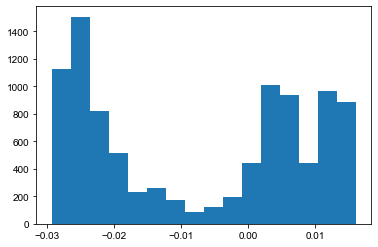

In [13]:
plot_tef_hist(tef)

Find average characteristics for people for whom treatment effect is positive and for whom treatment effect is negative (or alternatively above or below the mean)

In [14]:
np.mean(X[np.mean(tef,axis=0)>0],axis=0)

array([2.65449253e-01, 1.95820500e+03, 2.11899116e-01, 3.01573615e-01,
       5.61327872e-01, 4.40396637e-01, 1.78055615e-01, 4.44923475e-01,
       3.77020910e-01])

In [15]:
np.mean(X[np.mean(tef,axis=0)<0],axis=0)

array([2.76811540e-01, 1.97822998e+03, 5.06903353e-02, 7.55424063e-02,
       5.62919132e-01, 4.13806706e-01, 2.22682446e-01, 4.58974359e-01,
       3.18343195e-01])

#### Minimum leaf size 1000

In [16]:
#basic tree classifier
clf = tree.DecisionTreeRegressor(criterion='mse',min_samples_leaf=1000)

Train B trees to get a forest

In [17]:
tef, r, m, N = Causal_Forest_Estimator(X, y, D, W, s, B, clf)
print(np.mean(r))

IntProgress(value=0, max=10000)

0.0067790606931420255


Compute variance

In [18]:
compute_variance(N, tef)

0.0005932762040991328
0.002372371672662943
0.04870699818981809


Statistics of treatment effect (min, mean, max)

In [19]:
compute_statistics(tef)

Min treatment effect: -0.02434
Mean treatment effect: -0.00692
Max treatment effect: 0.01033


Plot of the heterogeneity of the treatment effect:

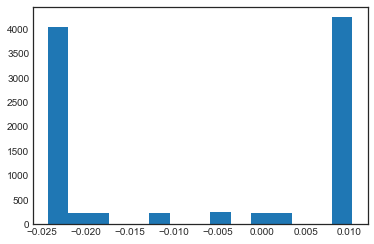

In [20]:
plot_tef_hist(tef)

Find average characteristics for people for whom treatment effect is positive and for whom treatment effect is negative (or alternatively above or below the mean)

In [21]:
np.mean(X[np.mean(tef,axis=0)>0],axis=0)

array([2.66033975e-01, 1.95832175e+03, 2.11395891e-01, 3.00148274e-01,
       5.38868884e-01, 4.63249312e-01, 1.90637577e-01, 4.41855539e-01,
       3.67506884e-01])

In [22]:
np.mean(X[np.mean(tef,axis=0)<0],axis=0)

array([2.76444907e-01, 1.97844868e+03, 4.85164395e-02, 7.31756215e-02,
       5.84202085e-01, 3.91740176e-01, 2.11507618e-01, 4.62109062e-01,
       3.26383320e-01])